This notebook contains the code for the meta-analysis of healthy lung data for ACE2, TMPRSS2, and CTSL. It contains the hold-out analysis for the simple model without interaction terms that was run on the cell-level data.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import patches
import seaborn as sns
import batchglm
import diffxpy.api as de
import patsy as pat
from statsmodels.stats.multitest import multipletests
import logging, warnings
import statsmodels.api as sm

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [87]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 655)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


'v0.7.3'

In [3]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study'

adata_diffxpy = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study/COVID19_lung_atlas_revision_v3.h5ad'

output_folder = 'diffxpy_out/'

de_output_base = 'COVID19_lung_atlas_revision_v3_lung_cov19_poissonglm_smoking_holdouts_nUMIoffset_noInts'

# Read the data

In [4]:
adata = sc.read(adata_diffxpy)

In [5]:
adata

AnnData object with n_obs × n_vars = 1320896 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new'

In [6]:
adata.obs.age = adata.obs.age.astype(float)

In [7]:
adata.obs.dtypes

age                         float64
anatomical_region          category
donor                      category
last_author/PI             category
lung_vs_nasal              category
notes                      category
original_celltype_ann      category
sample                     category
sex                        category
smoking                    category
total_counts                float64
smoked_boolean             category
last_author_sample_name    category
ann_level_1                category
ann_level_2                category
ann_level_3                category
ann_level_4                category
ann_level_5                category
ann_highest_res               int64
ann_new                        bool
dtype: object

In [8]:
adata.obs['dataset'] = adata.obs['last_author/PI']

In [9]:
adata.obs.dataset.value_counts()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    95303
Spence                      78401
Barbry/Leroy                76981
Krasnow/Quake               60993
Meyer                       57020
Rawlins                     53409
Regev                       43527
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Misharin                    28329
Xavier/Regev                25552
Spira/Campbell              24455
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Schultze                    22641
Schiller                    20776
Nawijn                      18197
Teichmann                   12971
Kropski/Banovich_dnar        8359
Shalek                       7603
Linnarsson                   4640
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      2207
Schultze/Falk                1965
Beane         

# Filter the data

Keep only datsets with:
- more than 1 donor
- non-fetal
- lung

In [10]:
# Remove fetal datasets
dats_to_remove = set(['Rawlins', 'Spence', 'Linnarsson'])

In [11]:
dat = adata.obs.groupby(['donor']).agg({'sex':'first', 'age':'first', 'dataset':'first'})

# Single donor filter
don_tab = dat['dataset'].value_counts()
dats_to_remove.update(set(don_tab.index[don_tab == 1]))

In [12]:
dats_to_remove = list(dats_to_remove)
dats_to_remove

['Spence', 'Schultze/Falk', 'Linnarsson', 'Misharin', 'Rawlins']

In [13]:
adata = adata[~adata.obs.dataset.isin(dats_to_remove)].copy()

In [14]:
adata.obs.lung_vs_nasal.value_counts()

lung     1096604
nasal      57548
Name: lung_vs_nasal, dtype: int64

In [15]:
# Filter for only lung data
adata = adata[adata.obs.lung_vs_nasal.isin(['lung']),].copy()

In [16]:
adata

AnnData object with n_obs × n_vars = 1096604 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset'

In [17]:
adata.obs['sample'].nunique()
adata.obs['donor'].nunique()
adata.obs['dataset'].nunique()

309

185

24

# Binarize smoking status

In [18]:
adata.obs.smoking.value_counts()

never              575345
current            173020
nan                111184
former              53487
non-smoker          42367
never-smoker        33119
active              29396
smoked              28197
current/former      23573
heavy               15663
current/former?      5162
light                3316
Former               1385
Current               610
Never Smoker          426
Current Smoker        354
Name: smoking, dtype: int64

In [19]:
adata.obs['smoking_status'] = adata.obs.smoked_boolean
#adata.obs['smoking_status'] = [True if stat in ['current', 'smoked', 'active', 'former', 'heavy', 'light'] else False if stat in ['never', 'nonsmoker'] else "nan" for stat in adata.obs.smoking]

In [20]:
adata.obs.smoking_status.value_counts()

False    651257
True     334163
nan      111184
Name: smoking_status, dtype: int64

## Filter out data w/o smoking status

In [21]:
pd.crosstab(adata.obs.dataset, adata.obs.smoking)

smoking,Current,Current Smoker,Former,Never Smoker,active,current,current/former,current/former?,former,heavy,light,nan,never,never-smoker,non-smoker,smoked
dataset,,,,,,,,,,,,,,,,
Barbry/Leroy,0,0,0,0,0,0,0,0,16423,0,0,0,0,0,42367,0
Beane,0,0,0,0,0,305,0,0,581,0,0,0,0,0,0,0
Beane/Campbell,0,354,0,426,0,0,0,0,0,0,0,0,0,0,0,0
Eils/Conrad/Kreuter,0,0,0,0,0,11185,0,0,0,0,0,0,28593,0,0,0
Kaminski,0,0,0,0,0,0,23573,0,0,0,0,3850,67880,0,0,0
Koenigshoff,0,0,0,0,0,0,0,0,0,0,0,0,0,33119,0,0
Krasnow/Quake,0,0,0,0,0,0,0,0,7524,0,0,0,53469,0,0,0
Kropski/Banovich_dnar,0,0,0,0,0,0,0,0,0,0,0,0,2647,0,0,5712
Kropski/Banovich_vand,0,0,0,0,0,0,0,0,0,0,0,0,800,0,0,22485


In [22]:
adata = adata[~adata.obs.smoking_status.isin(['nan']),].copy()
adata

AnnData object with n_obs × n_vars = 985420 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status'

In [23]:
adata.obs.dataset.value_counts()
adata.obs['sample'].nunique()
adata.obs['donor'].nunique()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    91453
Krasnow/Quake               60993
Barbry/Leroy                58790
Meyer                       57020
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Teichmann                   12971
Nawijn                      11110
Kropski/Banovich_dnar        8359
Schiller                     5162
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      1995
Beane                         886
Beane/Campbell                780
Name: dataset, dtype: int64

286

164

# Check the data

In [24]:
np.mean(adata.X.astype(int) != adata.X)

0.0

In [25]:
# Check if any non-integer data in a particular dataset
for dat in adata.obs.dataset.unique():
    val = np.mean(adata[adata.obs.dataset.isin([dat]),:].X.astype(int) != adata[adata.obs.dataset.isin([dat]),:].X)
    if val != 0:
        print(f'dataset= {dat}; value= {val}')
        adata[adata.obs.dataset.isin([dat]),:].X[:20,:20].A

All counts are integers

# Fit models and perform DE

In [26]:
cluster_key = 'ann_level_2'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Myeloid',
 'Airway epithelium',
 'Alveolar epithelium',
 'Lymphoid',
 'Fibroblast lineage',
 'Blood vessels',
 'Submucosal Gland',
 'Smooth Muscle',
 'Lymphatics',
 'Mesothelium']

Calculate DE genes per cluster.

In [27]:
adata

AnnData object with n_obs × n_vars = 985420 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status'

In [28]:
adata.obs['total_counts_scaled'] = adata.obs['total_counts']/adata.obs['total_counts'].mean()

In [29]:
formula = "1 + sex + age + smoking_status + dataset"
tested_coef = ["sex[T.male]", "age", "smoking_status[T.True]"]
dmat = de.utils.design_matrix(
    data=adata,
    formula="~" + formula,
    as_numeric=["age"],
    return_type="patsy"
)
dmat[1]

['Intercept',
 'sex[T.male]',
 'smoking_status[T.True]',
 'dataset[T.Beane]',
 'dataset[T.Beane/Campbell]',
 'dataset[T.Eils/Conrad/Kreuter]',
 'dataset[T.Kaminski]',
 'dataset[T.Koenigshoff]',
 'dataset[T.Krasnow/Quake]',
 'dataset[T.Kropski/Banovich_dnar]',
 'dataset[T.Kropski/Banovich_vand]',
 'dataset[T.Lafyatis/Rojas]',
 'dataset[T.Mazzilli/Campbell/Beane]',
 'dataset[T.Meyer]',
 'dataset[T.Meyer_b]',
 'dataset[T.Misharin/Budinger]',
 'dataset[T.Nawijn]',
 'dataset[T.Regev/Rajagopal]',
 'dataset[T.Schiller]',
 'dataset[T.Seibold]',
 'dataset[T.Teichmann]',
 'dataset[T.Whitsett/Xu_10X]',
 'dataset[T.Whitsett/Xu_dropSeq]',
 'age']

## Poisson GLM

In [30]:
# Poisson GLM loop
de_results_lvl2_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata[adata.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(pd.crosstab(adata_tmp_ho.obs['smoking_status'], adata_tmp_ho.obs['sex']))

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.smoking_status.value_counts())==1:
            print(f'{clust} only has 1 type of smoker/nonsmoker sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []        
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho, #[idx_train],
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(), #[idx_train, :], 
                exog=dmat[0], 
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()
            
            
            # Test over coefs
            for coef in tested_coef:
                de_results_temp = pois_results.wald_test(
                    [x for i, x in enumerate(pois_model.exog_names) if dmat[1][i] in [coef]]
                )

                # Output the results nicely
                de_results_temp = pd.DataFrame({
                    "gene": gene,
                    "cell_identity": clust,
                    "covariate": coef,
                    "holdout": ho,
                    "coef": pois_results.params[[y == coef for y in dmat[1]]],
                    "coef_sd": pois_results.bse[[y == coef for y in dmat[1]]],                                                   "pval": de_results_temp.pvalue
                }, index= [clust+"_"+gene+"_"+coef])

                de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl2_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl2_glm = pd.concat([de_results_lvl2_glm[i] for i in de_results_lvl2_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Myeloid:
sex             female   male
smoking_status               
False            90913  43790
True             23507  85268
Testing 3 genes...

Holdout Beane in cluster Myeloid:
sex             female   male
smoking_status               
False            92639  44802
True             24239  85239
Testing 3 genes...

Holdout Eils/Conrad/Kreuter in cluster Myeloid:
sex             female   male
smoking_status               
False            89780  43329
True             21046  85268
Testing 3 genes...

Holdout Kaminski in cluster Myeloid:
sex             female   male
smoking_status               
False            61094  23380
True             23508  67294
Testing 3 genes...

Holdout Krasnow/Quake in cluster Myeloid:
sex             female   male
smoking_status               
False            84942  36340
True             24248  81493
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Myeloid:
sex             female   male
smoking_status    

Testing 3 genes...

Holdout Lafyatis/Rojas in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            76318  46893
True             45698  14862
Testing 3 genes...

Holdout Meyer in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            72678  47244
True             45698  14425
Testing 3 genes...

Holdout Meyer_b in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            75922  47244
True             45354   9544
Testing 3 genes...

Holdout Misharin/Budinger in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            68687  44775
True             38667  12991
Testing 3 genes...

Holdout Regev/Rajagopal in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            44432  38846
True             17042  15087
Testing 3 genes...

Holdout Schiller 

Holdout Lafyatis/Rojas in cluster Blood vessels:
sex             female   male
smoking_status               
False             6781  12799
True              3084  17930
Testing 3 genes...

Holdout Meyer in cluster Blood vessels:
sex             female   male
smoking_status               
False             6906  13098
True              3084  16737
Testing 3 genes...

Holdout Meyer_b in cluster Blood vessels:
sex             female   male
smoking_status               
False             8069  13098
True              1619   5344
Testing 3 genes...

Holdout Misharin/Budinger in cluster Blood vessels:
sex             female   male
smoking_status               
False             8106  13061
True              2902  17881
Testing 3 genes...

Holdout Nawijn in cluster Blood vessels:
sex             female   male
smoking_status               
False             8357  12860
True              3058  17928
Testing 3 genes...

Holdout Schiller in cluster Blood vessels:
sex             female   male
smo

Testing 2 genes...



## Inspect some results

In [31]:
de_results_lvl2_glm.keys()

dict_keys(['Myeloid', 'Airway epithelium', 'Alveolar epithelium', 'Lymphoid', 'Fibroblast lineage', 'Blood vessels', 'Submucosal Gland', 'Smooth Muscle', 'Lymphatics', 'Mesothelium'])

In [32]:
full_res_lvl2_glm = full_res_lvl2_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])
full_res_lvl2_glm

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
145,ACE2,Airway epithelium,age,Barbry/Leroy,0.002879,0.001082,0.007783,0.008756
154,ACE2,Airway epithelium,age,Beane,0.003245,0.001073,0.002495,0.002807
163,ACE2,Airway epithelium,age,Beane/Campbell,0.003336,0.001075,0.001918,0.002158
172,ACE2,Airway epithelium,age,Eils/Conrad/Kreuter,0.003161,0.001071,0.003162,0.003557
181,ACE2,Airway epithelium,age,Kaminski,0.003178,0.001072,0.003036,0.003416
...,...,...,...,...,...,...,...,...
860,TMPRSS2,Submucosal Gland,smoking_status[T.True],Krasnow/Quake,-0.064357,0.024550,0.008754,0.011255
869,TMPRSS2,Submucosal Gland,smoking_status[T.True],Meyer_b,-0.070009,0.024552,0.004351,0.006527
878,TMPRSS2,Submucosal Gland,smoking_status[T.True],Nawijn,-0.063745,0.024597,0.009555,0.012284
887,TMPRSS2,Submucosal Gland,smoking_status[T.True],Regev/Rajagopal,-0.218514,0.074543,0.003375,0.011258


In [33]:
full_res_lvl2_glm.loc[(full_res_lvl2_glm['gene'] == 'ACE2') & (full_res_lvl2_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
145,ACE2,Airway epithelium,age,Barbry/Leroy,0.002879,0.001082,7.783423e-03,8.756350e-03
154,ACE2,Airway epithelium,age,Beane,0.003245,0.001073,2.495217e-03,2.807119e-03
163,ACE2,Airway epithelium,age,Beane/Campbell,0.003336,0.001075,1.918481e-03,2.158291e-03
172,ACE2,Airway epithelium,age,Eils/Conrad/Kreuter,0.003161,0.001071,3.161950e-03,3.557194e-03
181,ACE2,Airway epithelium,age,Kaminski,0.003178,0.001072,3.036259e-03,3.415792e-03
190,ACE2,Airway epithelium,age,Koenigshoff,0.003143,0.001069,3.285119e-03,3.695759e-03
199,ACE2,Airway epithelium,age,Krasnow/Quake,0.003341,0.001074,1.869253e-03,2.403325e-03
208,ACE2,Airway epithelium,age,Kropski/Banovich_dnar,0.003141,0.001069,3.299693e-03,3.712155e-03
217,ACE2,Airway epithelium,age,Kropski/Banovich_vand,0.003097,0.001072,3.850716e-03,4.332056e-03
226,ACE2,Airway epithelium,age,Lafyatis/Rojas,0.003229,0.001072,2.590911e-03,2.914775e-03


### Aggregate hold-out results statistics

In [64]:
def prop_signif(series):
    return (series < 0.05).mean()

def prop_pos(series):
    return (series > 0).mean()

def prop_pos_zero(series):
    return (series >= 0).mean()

def prop_neg_zero(series):
    return (series <= 0).mean()


In [35]:
res_summary_lvl2 = full_res_lvl2_glm.groupby(['gene', 'cell_identity', 'covariate']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()

res_summary_lvl2

gene        cell_identity               covariate   adj_pvals  \
                                                         prop_signif   
0      ACE2    Airway epithelium                     age    1.000000   
1      ACE2    Airway epithelium             sex[T.male]    0.809524   
2      ACE2    Airway epithelium  smoking_status[T.True]    0.904762   
3      ACE2  Alveolar epithelium                     age    0.937500   
4      ACE2  Alveolar epithelium             sex[T.male]    1.000000   
5      ACE2  Alveolar epithelium  smoking_status[T.True]    1.000000   
6      ACE2        Blood vessels                     age    0.000000   
7      ACE2        Blood vessels             sex[T.male]    0.000000   
8      ACE2        Blood vessels  smoking_status[T.True]    0.000000   
9      ACE2   Fibroblast lineage                     age    0.000000   
10     ACE2   Fibroblast lineage             sex[T.male]    0.000000   
11     ACE2   Fibroblast lineage  smoking_status[T.True]    0.000000   
12     ACE2             Lymphoid                     age    0.882353   
13     ACE2             Lymphoid             sex[T.male]    0.000000   
14     ACE2             Lymphoid  smoking_status[T.True]    0.000000   
15     ACE2              Myeloid                     age    0.000000   
16     ACE2              Myeloid             sex[T.male]    0.875000   
17     ACE2              Myeloid  smoking_status[T.True]    0.000000   
18     ACE2        Smooth Muscle                     age    0.000000   
19     ACE2        Smooth Muscle             sex[T.male]    0.000000   
20     ACE2        Smooth Muscle  smoking_status[T.True]    0.000000   
21     ACE2     Submucosal Gland                     age    0.000000   
22     ACE2     Submucosal Gland             sex[T.male]    0.000000   
23     ACE2     Submucosal Gland  smoking_status[T.True]    0.833333   
24     CTSL    Airway epithelium                     age    1.000000   
25     CTSL    Airway epithelium             sex[T.male]    1.000000   
26     CTSL    Airway epithelium  smoking_status[T.True]    1.000000   
27     CTSL  Alveolar epithelium                     age    0.937500   
28     CTSL  Alveolar epithelium             sex[T.male]    1.000000   
29     CTSL  Alveolar epithelium  smoking_status[T.True]    1.000000   
30     CTSL        Blood vessels                     age    0.000000   
31     CTSL        Blood vessels             sex[T.male]    0.818182   
32     CTSL        Blood vessels  smoking_status[T.True]    0.090909   
33     CTSL   Fibroblast lineage                     age    1.000000   
34     CTSL   Fibroblast lineage             sex[T.male]    1.000000   
35     CTSL   Fibroblast lineage  smoking_status[T.True]    1.000000   
36     CTSL           Lymphatics                     age    0.909091   
37     CTSL           Lymphatics             sex[T.male]    0.000000   
38     CTSL           Lymphatics  smoking_status[T.True]    0.000000   
39     CTSL             Lymphoid                     age    1.000000   
40     CTSL             Lymphoid             sex[T.male]    1.000000   
41     CTSL             Lymphoid  smoking_status[T.True]    1.000000   
42     CTSL          Mesothelium                     age    0.000000   
43     CTSL          Mesothelium             sex[T.male]    0.857143   
44     CTSL          Mesothelium  smoking_status[T.True]    0.000000   
45     CTSL              Myeloid                     age    1.000000   
46     CTSL              Myeloid             sex[T.male]    1.000000   
47     CTSL              Myeloid  smoking_status[T.True]    0.937500   
48     CTSL        Smooth Muscle                     age    1.000000   
49     CTSL        Smooth Muscle             sex[T.male]    1.000000   
50     CTSL        Smooth Muscle  smoking_status[T.True]    0.100000   
51     CTSL     Submucosal Gland                     age    0.833333   
52     CTSL     Submucosal Gland             sex[T.male]    0.833333   
53     CTSL     Submucosal Gland  smoking_statu

# Level 3 annotation

In [36]:
cluster_key = 'ann_level_3'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') or ct.startswith('2') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Macrophages',
 'Basal',
 'AT2',
 'T cell lineage',
 'Monocytes',
 'Multiciliated lineage',
 'Submucosal Secretory',
 'AT1',
 'Innate lymphoid cells',
 'Secretory',
 'Capillary',
 'Mast cells',
 'B cell lineage',
 'Fibroblasts',
 'Dendritic cells',
 'Venous',
 'Lymphatic EC',
 'Arterial',
 'Rare',
 'Airway smooth muscle']

In [37]:
adata_sub = adata[adata.obs.ann_level_3.isin(clusters),:]

adata_sub
adata_sub.obs.donor.nunique()
adata_sub.obs['sample'].nunique()

View of AnnData object with n_obs × n_vars = 795195 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status', 'total_counts_scaled'

164

286

## Poisson GLM

In [38]:
# Poisson GLM loop
de_results_lvl3_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata_sub[adata_sub.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(pd.crosstab(adata_tmp_ho.obs['smoking_status'], adata_tmp_ho.obs['sex']))

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.smoking_status.value_counts())==1:
            print(f'{clust} only has 1 type of smoker/nonsmoker sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []        
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho,
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(),
                exog=dmat[0],
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()
            
            
            # Test over coefs
            for coef in tested_coef:
                de_results_temp = pois_results.wald_test(
                    [x for i, x in enumerate(pois_model.exog_names) if dmat[1][i] in [coef]]
                )

                # Output the results nicely
                de_results_temp = pd.DataFrame({
                    "gene": gene,
                    "cell_identity": clust,
                    "covariate": coef,
                    "holdout": ho,
                    "coef": pois_results.params[[y == coef for y in dmat[1]]],
                    "coef_sd": pois_results.bse[[y == coef for y in dmat[1]]],                    
                    "pval": de_results_temp.pvalue
                }, index= [clust+"_"+gene+"_"+coef])

                de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl3_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl3_glm = pd.concat([de_results_lvl3_glm[i] for i in de_results_lvl3_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Macrophages:
sex             female   male
smoking_status               
False            51291  31345
True              9376  62625
Testing 3 genes...

Holdout Kaminski in cluster Macrophages:
sex             female   male
smoking_status               
False            25956  12047
True              9452  46817
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Krasnow/Quake in cluster Macrophages:
sex             female   male
smoking_status               
False            47175  25155
True              9802  59293
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Macrophages:
sex             female   male
smoking_status               
False            52031  31751
True              9802  61361
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Macrophages:
sex             female   male
smoking_status               
False            52766  31751
True              7720  54542
Testing 3 genes...


Holdout Kaminski in cluster T cell lineage:
sex             female   male
smoking_status               
False            17339   2923
True              5682  18419
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Krasnow/Quake in cluster T cell lineage:
sex             female   male
smoking_status               
False            18803   2104
True              5744  20264
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster T cell lineage:
sex             female   male
smoking_status               
False            21891   3706
True              5744  20490
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster T cell lineage:
sex             female   male
smoking_status               
False            21419   3706
True              3956  20443
Testing 3 genes...

Holdout Lafyatis/Rojas in cluster T cell lineage:
sex             female   male
smoking_status               
False            20184   3042
True              5744  20432
Te

Holdout Krasnow/Quake in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            14958  10352
True              4786   3050
Testing 3 genes...

Holdout Meyer_b in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            15088  10710
True              4670    838
Testing 3 genes...

Holdout Nawijn in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            15115  10613
True              4726   3036
Testing 3 genes...

Holdout Regev/Rajagopal in cluster Submucosal Secretory:
sex             female  male
smoking_status              
False              672  2462
True               892  3050
Testing 3 genes...

Holdout Seibold in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            14723  10003
True              4391   2226
Testing 3 genes...

Holdout Barbry/Leroy in cluster AT1:
sex      

Holdout Nawijn in cluster Secretory:
sex             female  male
smoking_status              
False             6596  6614
True              3813  3217
Testing 3 genes...

Holdout Schiller in cluster Secretory:
sex             female  male
smoking_status              
False             6596  7854
True              4207  3411
Testing 3 genes...

Holdout Seibold in cluster Secretory:
sex             female  male
smoking_status              
False             6143  7016
True              3621  2547
Testing 3 genes...

Holdout Teichmann in cluster Secretory:
sex             female  male
smoking_status              
False             6596  7854
True              4199  3645
Testing 3 genes...

Holdout Whitsett/Xu_10X in cluster Secretory:
sex             female  male
smoking_status              
False             6337  6912
True              4207  3649
Testing 3 genes...

Holdout Kaminski in cluster Capillary:
sex             female  male
smoking_status              
False             2258 

Holdout Kaminski in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3978  2862
True               478  1770
Testing 3 genes...

Holdout Krasnow/Quake in cluster Fibroblasts:
sex             female  male
smoking_status              
False             2381  1264
True               478  1493
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3959  2872
True               478  1771
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3980  2872
True               456  1690
Testing 3 genes...

Holdout Meyer_b in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3982  2872
True               321   403
Testing 3 genes...

Holdout Nawijn in cluster Fibroblasts:
sex             female  male
smoking_status   

Testing 1 genes...

Holdout Meyer_b in cluster Arterial:
sex             female  male
smoking_status              
False              530  1056
True                33   269
filtered out 2 genes that are detected in less than 10 cells
Testing 1 genes...

Holdout Nawijn in cluster Arterial:
sex             female  male
smoking_status              
False              593  1017
True               323  1502
filtered out 2 genes that are detected in less than 10 cells
Testing 1 genes...

Holdout Barbry/Leroy in cluster Rare:
sex             female  male
smoking_status              
False              847  1231
True               254   162
Testing 3 genes...

Holdout Beane in cluster Rare:
sex             female  male
smoking_status              
False              892  1326
True               284   153
Testing 3 genes...

Holdout Beane/Campbell in cluster Rare:
sex             female  male
smoking_status              
False              892  1322
True               294   155
Testing 3 genes.

## Inspect some results

In [39]:
de_results_lvl3_glm.keys()

dict_keys(['Macrophages', 'Basal', 'AT2', 'T cell lineage', 'Monocytes', 'Multiciliated lineage', 'Submucosal Secretory', 'AT1', 'Innate lymphoid cells', 'Secretory', 'Capillary', 'Mast cells', 'B cell lineage', 'Fibroblasts', 'Dendritic cells', 'Venous', 'Lymphatic EC', 'Arterial', 'Rare', 'Airway smooth muscle'])

In [40]:
full_res_lvl3_glm = full_res_lvl3_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])


In [41]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'ACE2']

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
829,ACE2,AT1,age,Barbry/Leroy,0.011905,0.006286,5.823080e-02,6.622207e-02
838,ACE2,AT1,age,Eils/Conrad/Kreuter,0.010405,0.007328,1.556708e-01,1.751297e-01
847,ACE2,AT1,age,Kaminski,0.014524,0.006328,2.172454e-02,2.793155e-02
856,ACE2,AT1,age,Koenigshoff,0.011905,0.006286,5.823080e-02,6.803722e-02
865,ACE2,AT1,age,Krasnow/Quake,0.012046,0.006284,5.526450e-02,7.105436e-02
874,ACE2,AT1,age,Kropski/Banovich_dnar,0.011905,0.006286,5.823080e-02,7.463304e-02
883,ACE2,AT1,age,Kropski/Banovich_vand,0.012027,0.006293,5.597933e-02,6.911539e-02
892,ACE2,AT1,age,Lafyatis/Rojas,0.011905,0.006286,5.823080e-02,6.550964e-02
901,ACE2,AT1,age,Meyer,0.011597,0.006334,6.711386e-02,8.628925e-02
910,ACE2,AT1,age,Meyer_b,0.011710,0.006331,6.439386e-02,7.244309e-02


In [42]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'TMPRSS2']

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
832,TMPRSS2,AT1,age,Barbry/Leroy,0.011882,0.000746,4.273932e-57,1.923269e-56
841,TMPRSS2,AT1,age,Eils/Conrad/Kreuter,0.019259,0.000909,1.223466e-99,5.505597e-99
850,TMPRSS2,AT1,age,Kaminski,0.012308,0.000756,1.361239e-59,6.125575e-59
859,TMPRSS2,AT1,age,Koenigshoff,0.011875,0.000746,5.209472e-57,2.344262e-56
868,TMPRSS2,AT1,age,Krasnow/Quake,0.012167,0.000749,2.681060e-59,1.206477e-58
...,...,...,...,...,...,...,...,...
449,TMPRSS2,T cell lineage,smoking_status[T.True],Mazzilli/Campbell/Beane,-0.099401,0.116712,3.943918e-01,4.436908e-01
458,TMPRSS2,T cell lineage,smoking_status[T.True],Meyer,0.302357,0.130578,2.058419e-02,3.705154e-02
467,TMPRSS2,T cell lineage,smoking_status[T.True],Meyer_b,-0.075335,0.116462,5.177240e-01,5.824395e-01
476,TMPRSS2,T cell lineage,smoking_status[T.True],Nawijn,-0.099137,0.116738,3.957565e-01,4.452260e-01


In [88]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'CTSL']

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
835,CTSL,AT1,age,Barbry/Leroy,1.546661e-03,0.000819,5.886407e-02,6.622207e-02
844,CTSL,AT1,age,Eils/Conrad/Kreuter,2.109503e-03,0.000905,1.975008e-02,2.962511e-02
853,CTSL,AT1,age,Kaminski,1.513988e-03,0.000824,6.614273e-02,7.441057e-02
862,CTSL,AT1,age,Koenigshoff,1.536873e-03,0.000819,6.047753e-02,6.803722e-02
871,CTSL,AT1,age,Krasnow/Quake,1.363655e-03,0.000818,9.565031e-02,1.076066e-01
880,CTSL,AT1,age,Kropski/Banovich_dnar,1.504139e-03,0.000819,6.634048e-02,7.463304e-02
889,CTSL,AT1,age,Kropski/Banovich_vand,1.534886e-03,0.000821,6.143591e-02,6.911539e-02
898,CTSL,AT1,age,Lafyatis/Rojas,2.259852e-03,0.000821,5.929177e-03,8.893765e-03
907,CTSL,AT1,age,Meyer,1.356594e-03,0.000830,1.022360e-01,1.150155e-01
916,CTSL,AT1,age,Meyer_b,1.562342e-03,0.000825,5.832168e-02,7.244309e-02


In [44]:
full_res_lvl3_glm.loc[(full_res_lvl3_glm['gene'] == 'ACE2') & (full_res_lvl3_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,holdout,coef,coef_sd,pval,adj_pvals
847,ACE2,AT1,age,Kaminski,0.014524,0.006328,2.172454e-02,2.793155e-02
919,ACE2,AT1,age,Misharin/Budinger,0.015449,0.006398,1.574441e-02,2.361662e-02
828,ACE2,AT1,sex[T.male],Barbry/Leroy,0.483887,0.205510,1.854418e-02,2.781628e-02
846,ACE2,AT1,sex[T.male],Kaminski,0.576221,0.208697,5.761743e-03,8.642614e-03
855,ACE2,AT1,sex[T.male],Koenigshoff,0.483887,0.205510,1.854418e-02,2.781628e-02
864,ACE2,AT1,sex[T.male],Krasnow/Quake,0.463148,0.207450,2.557644e-02,3.836466e-02
873,ACE2,AT1,sex[T.male],Kropski/Banovich_dnar,0.483887,0.205510,1.854418e-02,2.781628e-02
882,ACE2,AT1,sex[T.male],Kropski/Banovich_vand,0.499628,0.205921,1.525327e-02,2.287990e-02
891,ACE2,AT1,sex[T.male],Lafyatis/Rojas,0.483887,0.205510,1.854418e-02,2.384252e-02
900,ACE2,AT1,sex[T.male],Meyer,0.470474,0.209875,2.498153e-02,3.747230e-02


### Aggregate hold-out results statistics

In [65]:
full_res_lvl3_glm.groupby(['gene', 'cell_identity', 'covariate']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
})

adj_pvals      coef  \
                                                     prop_signif      mean   
gene    cell_identity         covariate                                      
ACE2    AT1                   age                       0.125000  0.011232   
                              sex[T.male]               0.812500  0.486755   
                              smoking_status[T.True]    0.000000  0.280517   
        AT2                   age                       0.937500  0.018441   
                              sex[T.male]               1.000000  0.818369   
                              smoking_status[T.True]    1.000000 -0.417737   
        Basal                 age                       1.000000  0.003216   
                              sex[T.male]               0.071429  0.058706   
                              smoking_status[T.True]    0.928571  0.187579   
        Fibroblasts           age                       0.000000 -0.127373   
                              sex[T.male]               0.375000 -1.613055   
                              smoking_status[T.True]    0.000000  3.254104   
        Macrophages           age                       0.000000  0.006819   
                              sex[T.male]               0.000000  0.089493   
                              smoking_status[T.True]    0.000000 -0.202564   
        Monocytes             age                       0.000000 -0.025427   
                              sex[T.male]               0.000000  0.724631   
                              smoking_status[T.True]    0.000000 -0.292981   
        Multiciliated lineage age                       0.950000  0.006666   
                              sex[T.male]               0.950000  0.241750   
                              smoking_status[T.True]    0.200000  0.202167   
        Rare                  age                       0.000000  0.007882   
                              sex[T.male]               0.000000 -0.252432   
                              smoking_status[T.True]    0.000000  0.248551   
        Secretory             age                       0.222222 -0.007814   
                              sex[T.male]               0.944444  0.248812   
                              smoking_status[T.True]    0.000000 -0.012533   
        Submucosal Secretory  age                       0.000000  0.002695   
                              sex[T.male]               0.000000  0.049399   
                              smoking_status[T.True]    0.833333  0.441501   
        T cell lineage        age                       0.000000 -0.011855   
                              sex[T.male]               0.000000  0.616427   
                              smoking_status[T.True]    0.000000 -0.665337   
CTSL    AT1                   age                       0.187500  0.000995   
                              sex[T.male]               0.937500  0.249195   
                              smoking_status[T.True]    1.000000  0.146384   
        AT2                   age                       0.937500 -0.005329   
                              sex[T.male]               1.000000  0.106914   
                              smoking_status[T.True]    1.000000  0.108800   
        Airway smooth muscle  age                       0.666667 -0.006320   
                              sex[T.male]               0.333333 -0.111671   
                              smoking_status[T.True]    0.333333  0.114416   
        Arterial              age                       0.250000  0.004618   
                              sex[T.male]               0.250000  0.140710   
                              smoking_status[T.True]    0.000000 -0.149946   
        B cell lineage        age                       0.083333 -0.002390   
                              sex[T.male]               0.166667 -0.176095   
                              smoking_status[T.True]    0.000000 -0.098878   
        Basal                 age                       1.000000  0.005372   

In [66]:
res_summary_lvl3 = full_res_lvl3_glm.groupby(['gene', 'cell_identity', 'covariate']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()
res_summary_lvl3

gene          cell_identity               covariate   adj_pvals  \
                                                            prop_signif   
0       ACE2                    AT1                     age    0.125000   
1       ACE2                    AT1             sex[T.male]    0.812500   
2       ACE2                    AT1  smoking_status[T.True]    0.000000   
3       ACE2                    AT2                     age    0.937500   
4       ACE2                    AT2             sex[T.male]    1.000000   
5       ACE2                    AT2  smoking_status[T.True]    1.000000   
6       ACE2                  Basal                     age    1.000000   
7       ACE2                  Basal             sex[T.male]    0.071429   
8       ACE2                  Basal  smoking_status[T.True]    0.928571   
9       ACE2            Fibroblasts                     age    0.000000   
10      ACE2            Fibroblasts             sex[T.male]    0.375000   
11      ACE2            Fibroblasts  smoking_status[T.True]    0.000000   
12      ACE2            Macrophages                     age    0.000000   
13      ACE2            Macrophages             sex[T.male]    0.000000   
14      ACE2            Macrophages  smoking_status[T.True]    0.000000   
15      ACE2              Monocytes                     age    0.000000   
16      ACE2              Monocytes             sex[T.male]    0.000000   
17      ACE2              Monocytes  smoking_status[T.True]    0.000000   
18      ACE2  Multiciliated lineage                     age    0.950000   
19      ACE2  Multiciliated lineage             sex[T.male]    0.950000   
20      ACE2  Multiciliated lineage  smoking_status[T.True]    0.200000   
21      ACE2                   Rare                     age    0.000000   
22      ACE2                   Rare             sex[T.male]    0.000000   
23      ACE2                   Rare  smoking_status[T.True]    0.000000   
24      ACE2              Secretory                     age    0.222222   
25      ACE2              Secretory             sex[T.male]    0.944444   
26      ACE2              Secretory  smoking_status[T.True]    0.000000   
27      ACE2   Submucosal Secretory                     age    0.000000   
28      ACE2   Submucosal Secretory             sex[T.male]    0.000000   
29      ACE2   Submucosal Secretory  smoking_status[T.True]    0.833333   
30      ACE2         T cell lineage                     age    0.000000   
31      ACE2         T cell lineage             sex[T.male]    0.000000   
32      ACE2         T cell lineage  smoking_status[T.True]    0.000000   
33      CTSL                    AT1                     age    0.187500   
34      CTSL                    AT1             sex[T.male]    0.937500   
35      CTSL                    AT1  smoking_status[T.True]    1.000000   
36      CTSL                    AT2                     age    0.937500   
37      CTSL                    AT2             sex[T.male]    1.000000   
38      CTSL                    AT2  smoking_status[T.True]    1.000000   
39      CTSL   Airway smooth muscle                     age    0.666667   
40      CTSL   Airway smooth muscle             sex[T.male]    0.333333   
41      CTSL   Airway smooth muscle  smoking_status[T.True]    0.333333   
42      CTSL               Arterial                     age    0.250000   
43      CTSL               Arterial             sex[T.male]    0.250000   
44      CTSL               Arterial  smoking_status[T.True]    0.000000   
45      CTSL         B cell lineage                     age    0.083333   
46      CTSL         B cell lineage             sex[T.male]    0.166667   
47      CTSL         B cell lineage  smoking_status[T.True]    0.000000   
48      CTSL                  Basal                     age    1.000000   
49      CTSL                  Basal             sex[T.male]    1.000000   
50      CTSL                  Basal  smoking_status[T.True]    1.000000   
51      CTSL              Capilla

In [67]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity               covariate   adj_pvals      coef  \
                                                        prop_signif      mean   
0   ACE2                    AT1                     age    0.125000  0.011232   
1   ACE2                    AT1             sex[T.male]    0.812500  0.486755   
2   ACE2                    AT1  smoking_status[T.True]    0.000000  0.280517   
3   ACE2                    AT2                     age    0.937500  0.018441   
4   ACE2                    AT2             sex[T.male]    1.000000  0.818369   
5   ACE2                    AT2  smoking_status[T.True]    1.000000 -0.417737   
6   ACE2                  Basal                     age    1.000000  0.003216   
7   ACE2                  Basal             sex[T.male]    0.071429  0.058706   
8   ACE2                  Basal  smoking_status[T.True]    0.928571  0.187579   
9   ACE2            Fibroblasts                     age    0.000000 -0.127373   
10  ACE2            Fibroblasts             sex[T.male]    0.375000 -1.613055   
11  ACE2            Fibroblasts  smoking_status[T.True]    0.000000  3.254104   
12  ACE2            Macrophages                     age    0.000000  0.006819   
13  ACE2            Macrophages             sex[T.male]    0.000000  0.089493   
14  ACE2            Macrophages  smoking_status[T.True]    0.000000 -0.202564   
15  ACE2              Monocytes                     age    0.000000 -0.025427   
16  ACE2              Monocytes             sex[T.male]    0.000000  0.724631   
17  ACE2              Monocytes  smoking_status[T.True]    0.000000 -0.292981   
18  ACE2  Multiciliated lineage                     age    0.950000  0.006666   
19  ACE2  Multiciliated lineage             sex[T.male]    0.950000  0.241750   
20  ACE2  Multiciliated lineage  smoking_status[T.True]    0.200000  0.202167   
21  ACE2                   Rare                     age    0.000000  0.007882   
22  ACE2                   Rare             sex[T.male]    0.000000 -0.252432   
23  ACE2                   Rare  smoking_status[T.True]    0.000000  0.248551   
24  ACE2              Secretory                     age    0.222222 -0.007814   
25  ACE2              Secretory             sex[T.male]    0.944444  0.248812   
27  ACE2   Submucosal Secretory                     age    0.000000  0.002695   
28  ACE2   Submucosal Secretory             sex[T.male]    0.000000  0.049399   
29  ACE2   Submucosal Secretory  smoking_status[T.True]    0.833333  0.441501   
30  ACE2         T cell lineage                     age    0.000000 -0.011855   
31  ACE2         T cell lineage             sex[T.male]    0.000000  0.616427   
32  ACE2         T cell lineage  smoking_status[T.True]    0.000000 -0.665337   

                        holdout  
          std  prop_pos   count  
0    0.004125  0.937500      16  
1    0.084715  1.000000      16  
2    0.026595  1.000000      16  
3    0.004966  1.000000      16  
4    0.084903  1.000000      16  
5    0.088215  0.000000      16  
6    0.003008  0.928571      14  
7    0.076977  0.928571      14  
8    0.029586  1.000000      14  
9    0.349079  0.000000       8  
10   1.527449  0.000000       8  
11  10.263070  0.125000       8  
12   0.000267  1.000000      11  
13   0.025746  1.000000      11  
14   0.044114  0.000000      11  
15   0.001425  0.000000      11  
16   0.042680  1.000000      11  
17   0.018323  0.000000      11  
18   0.002044  0.950000      20  
19   0.100486  0.950000      20  
20   0.019279  1.000000      20  
21   0.005543  0.888889       9  
22   0.280972  0.111111       9  
23   0.165912  1.000000       9  
24   0.002589  0.000000      18  
25   0.037251  1.000000      18  
27   0.000729  1.000000       6  
28   0.047474  1.000000       6  
29   0.096215  1.000000       6  
30   0.001812  0.000000      12  
31   0.047929  1.000000      12  
32   0.159363  0.000000      12

gene          cell_identity               covariate   adj_pvals      coef  \
                                                        prop_signif      mean   
1   ACE2                    AT1             sex[T.male]    0.812500  0.486755   
3   ACE2                    AT2                     age    0.937500  0.018441   
4   ACE2                    AT2             sex[T.male]    1.000000  0.818369   
5   ACE2                    AT2  smoking_status[T.True]    1.000000 -0.417737   
6   ACE2                  Basal                     age    1.000000  0.003216   
8   ACE2                  Basal  smoking_status[T.True]    0.928571  0.187579   
18  ACE2  Multiciliated lineage                     age    0.950000  0.006666   
19  ACE2  Multiciliated lineage             sex[T.male]    0.950000  0.241750   
25  ACE2              Secretory             sex[T.male]    0.944444  0.248812   
29  ACE2   Submucosal Secretory  smoking_status[T.True]    0.833333  0.441501   

                       holdout  
         std  prop_pos   count  
1   0.084715  1.000000      16  
3   0.004966  1.000000      16  
4   0.084903  1.000000      16  
5   0.088215  0.000000      16  
6   0.003008  0.928571      14  
8   0.029586  1.000000      14  
18  0.002044  0.950000      20  
19  0.100486  0.950000      20  
25  0.037251  1.000000      18  
29  0.096215  1.000000       6

In [71]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity               covariate   adj_pvals  \
                                                            prop_signif   
93   TMPRSS2                    AT1                     age    1.000000   
94   TMPRSS2                    AT1             sex[T.male]    1.000000   
95   TMPRSS2                    AT1  smoking_status[T.True]    0.937500   
96   TMPRSS2                    AT2                     age    1.000000   
98   TMPRSS2                    AT2  smoking_status[T.True]    1.000000   
99   TMPRSS2         B cell lineage                     age    0.000000   
100  TMPRSS2         B cell lineage             sex[T.male]    0.000000   
101  TMPRSS2         B cell lineage  smoking_status[T.True]    0.000000   
102  TMPRSS2                  Basal                     age    1.000000   
103  TMPRSS2                  Basal             sex[T.male]    1.000000   
104  TMPRSS2                  Basal  smoking_status[T.True]    1.000000   
108  TMPRSS2        Dendritic cells                     age    0.000000   
109  TMPRSS2        Dendritic cells             sex[T.male]    0.000000   
110  TMPRSS2        Dendritic cells  smoking_status[T.True]    0.083333   
112  TMPRSS2            Fibroblasts             sex[T.male]    0.142857   
113  TMPRSS2            Fibroblasts  smoking_status[T.True]    0.000000   
114  TMPRSS2  Innate lymphoid cells                     age    0.000000   
115  TMPRSS2  Innate lymphoid cells             sex[T.male]    0.000000   
116  TMPRSS2  Innate lymphoid cells  smoking_status[T.True]    0.000000   
117  TMPRSS2           Lymphatic EC                     age    0.000000   
118  TMPRSS2           Lymphatic EC             sex[T.male]    0.909091   
119  TMPRSS2           Lymphatic EC  smoking_status[T.True]    0.000000   
120  TMPRSS2            Macrophages                     age    0.166667   
121  TMPRSS2            Macrophages             sex[T.male]    1.000000   
122  TMPRSS2            Macrophages  smoking_status[T.True]    0.000000   
123  TMPRSS2             Mast cells                     age    0.000000   
124  TMPRSS2             Mast cells             sex[T.male]    0.000000   
125  TMPRSS2             Mast cells  smoking_status[T.True]    0.000000   
126  TMPRSS2              Monocytes                     age    0.916667   
127  TMPRSS2              Monocytes             sex[T.male]    0.916667   
128  TMPRSS2              Monocytes  smoking_status[T.True]    0.166667   
129  TMPRSS2  Multiciliated lineage                     age    0.100000   
130  TMPRSS2  Multiciliated lineage             sex[T.male]    1.000000   
131  TMPRSS2  Multiciliated lineage  smoking_status[T.True]    0.900000   
132  TMPRSS2                   Rare                     age    0.000000   
133  TMPRSS2                   Rare             sex[T.male]    0.700000   
134  TMPRSS2                   Rare  smoking_status[T.True]    0.100000   
135  TMPRSS2              Secretory                     age    0.944444   
136  TMPRSS2              Secretory             sex[T.male]    1.000000   
138  TMPRSS2   Submucosal Secretory                     age    1.000000   
139  TMPRSS2   Submucosal Secretory             sex[T.male]    1.000000   
140  TMPRSS2   Submucosal Secretory  smoking_status[T.True]    0.833333   
141  TMPRSS2         T cell lineage                     age    0.076923   
142  TMPRSS2         T cell lineage             sex[T.male]    0.923077   
143  TMPRSS2         T cell lineage  smoking_status[T.True]    0.153846   

         coef                     holdout  
         mean       std  prop_pos   count  
93   0.011457  0.004963  0.937500      16  
94   0.674407  0.054210  1.000000      16  
95   0.080952  0.082551  0.875000      16  
96   0.020388  0.005234  1.000000      16  
98   0.119114  0.060289  0.937500      16  
99  -0.006207  0.007589  0.166667      12  
100  0.250902  0.256498  0.916667      12  
101 -0.595795  0.332483  0.083333      12  
102  0.004519  0.004030  0.928571      14 

gene          cell_identity               covariate   adj_pvals  \
                                                            prop_signif   
93   TMPRSS2                    AT1                     age    1.000000   
94   TMPRSS2                    AT1             sex[T.male]    1.000000   
95   TMPRSS2                    AT1  smoking_status[T.True]    0.937500   
96   TMPRSS2                    AT2                     age    1.000000   
98   TMPRSS2                    AT2  smoking_status[T.True]    1.000000   
102  TMPRSS2                  Basal                     age    1.000000   
103  TMPRSS2                  Basal             sex[T.male]    1.000000   
104  TMPRSS2                  Basal  smoking_status[T.True]    1.000000   
118  TMPRSS2           Lymphatic EC             sex[T.male]    0.909091   
121  TMPRSS2            Macrophages             sex[T.male]    1.000000   
126  TMPRSS2              Monocytes                     age    0.916667   
127  TMPRSS2              Monocytes             sex[T.male]    0.916667   
130  TMPRSS2  Multiciliated lineage             sex[T.male]    1.000000   
131  TMPRSS2  Multiciliated lineage  smoking_status[T.True]    0.900000   
133  TMPRSS2                   Rare             sex[T.male]    0.700000   
135  TMPRSS2              Secretory                     age    0.944444   
136  TMPRSS2              Secretory             sex[T.male]    1.000000   
138  TMPRSS2   Submucosal Secretory                     age    1.000000   
139  TMPRSS2   Submucosal Secretory             sex[T.male]    1.000000   
140  TMPRSS2   Submucosal Secretory  smoking_status[T.True]    0.833333   
142  TMPRSS2         T cell lineage             sex[T.male]    0.923077   

         coef                     holdout  
         mean       std  prop_pos   count  
93   0.011457  0.004963  0.937500      16  
94   0.674407  0.054210  1.000000      16  
95   0.080952  0.082551  0.875000      16  
96   0.020388  0.005234  1.000000      16  
98   0.119114  0.060289  0.937500      16  
102  0.004519  0.004030  0.928571      14  
103  0.308249  0.033850  1.000000      14  
104 -0.363469  0.077466  0.000000      14  
118  0.557797  0.089432  1.000000      11  
121 -0.341463  0.086944  0.000000      12  
126  0.007313  0.003555  0.916667      12  
127  1.139014  0.304264  1.000000      12  
130  0.179457  0.015762  1.000000      20  
131 -0.083233  0.021051  0.000000      20  
133  0.287410  0.149085  0.900000      10  
135 -0.003425  0.000493  0.000000      18  
136  0.264654  0.026744  1.000000      18  
138  0.000578  0.004102  0.833333       6  
139  0.284074  0.077183  1.000000       6  
140 -0.088711  0.064074  0.000000       6  
142  0.388283  0.108107  1.000000      13

In [72]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity               covariate   adj_pvals      coef  \
                                                        prop_signif      mean   
33  CTSL                    AT1                     age    0.187500  0.000995   
34  CTSL                    AT1             sex[T.male]    0.937500  0.249195   
35  CTSL                    AT1  smoking_status[T.True]    1.000000  0.146384   
36  CTSL                    AT2                     age    0.937500 -0.005329   
37  CTSL                    AT2             sex[T.male]    1.000000  0.106914   
38  CTSL                    AT2  smoking_status[T.True]    1.000000  0.108800   
42  CTSL               Arterial                     age    0.250000  0.004618   
43  CTSL               Arterial             sex[T.male]    0.250000  0.140710   
45  CTSL         B cell lineage                     age    0.083333 -0.002390   
46  CTSL         B cell lineage             sex[T.male]    0.166667 -0.176095   
47  CTSL         B cell lineage  smoking_status[T.True]    0.000000 -0.098878   
48  CTSL                  Basal                     age    1.000000  0.005372   
49  CTSL                  Basal             sex[T.male]    1.000000 -0.168716   
50  CTSL                  Basal  smoking_status[T.True]    1.000000  0.072813   
51  CTSL              Capillary                     age    0.000000 -0.001290   
53  CTSL              Capillary  smoking_status[T.True]    0.750000  0.263900   
54  CTSL        Dendritic cells                     age    0.916667  0.015537   
55  CTSL        Dendritic cells             sex[T.male]    1.000000 -0.415297   
56  CTSL        Dendritic cells  smoking_status[T.True]    0.916667 -0.187462   
57  CTSL            Fibroblasts                     age    1.000000 -0.016653   
59  CTSL            Fibroblasts  smoking_status[T.True]    0.875000  0.945193   
60  CTSL  Innate lymphoid cells                     age    1.000000  0.019129   
61  CTSL  Innate lymphoid cells             sex[T.male]    0.888889  0.442373   
62  CTSL  Innate lymphoid cells  smoking_status[T.True]    1.000000  0.345285   
63  CTSL           Lymphatic EC                     age    0.909091  0.004303   
64  CTSL           Lymphatic EC             sex[T.male]    0.000000  0.017678   
65  CTSL           Lymphatic EC  smoking_status[T.True]    0.000000 -0.021580   
66  CTSL            Macrophages                     age    0.916667  0.002632   
67  CTSL            Macrophages             sex[T.male]    1.000000 -0.164072   
68  CTSL            Macrophages  smoking_status[T.True]    1.000000  0.098084   
69  CTSL             Mast cells                     age    0.857143 -0.007259   
70  CTSL             Mast cells             sex[T.male]    0.857143 -0.210549   
71  CTSL             Mast cells  smoking_status[T.True]    0.928571 -0.363431   
72  CTSL              Monocytes                     age    0.833333 -0.001859   
73  CTSL              Monocytes             sex[T.male]    1.000000 -0.147369   
74  CTSL              Monocytes  smoking_status[T.True]    1.000000 -0.158622   
75  CTSL  Multiciliated lineage                     age    0.850000 -0.001253   
76  CTSL  Multiciliated lineage             sex[T.male]    0.950000 -0.060123   
77  CTSL  Multiciliated lineage  smoking_status[T.True]    0.000000  0.004921   
78  CTSL                   Rare                     age    0.900000  0.007632   
79  CTSL                   Rare             sex[T.male]    1.000000  0.273914   
80  CTSL                   Rare  smoking_status[T.True]    1.000000  0.290189   
81  CTSL              Secretory                     age    0.944444  0.004983   
83  CTSL              Secretory  smoking_status[T.True]    0.000000  0.043022   
84  CTSL   Submucosal Secretory                     age    0.833333  0.006139   
85  CTSL   Submucosal Secretory             sex[T.male]    0.833333 -0.080331   
86  CTSL   Submucosal Secretory  smoking_status[T.True]    0.833333  0.075365   
87  CTSL         T cell lineage    

gene          cell_identity               covariate   adj_pvals      coef  \
                                                        prop_signif      mean   
34  CTSL                    AT1             sex[T.male]    0.937500  0.249195   
35  CTSL                    AT1  smoking_status[T.True]    1.000000  0.146384   
36  CTSL                    AT2                     age    0.937500 -0.005329   
37  CTSL                    AT2             sex[T.male]    1.000000  0.106914   
38  CTSL                    AT2  smoking_status[T.True]    1.000000  0.108800   
48  CTSL                  Basal                     age    1.000000  0.005372   
49  CTSL                  Basal             sex[T.male]    1.000000 -0.168716   
50  CTSL                  Basal  smoking_status[T.True]    1.000000  0.072813   
53  CTSL              Capillary  smoking_status[T.True]    0.750000  0.263900   
54  CTSL        Dendritic cells                     age    0.916667  0.015537   
55  CTSL        Dendritic cells             sex[T.male]    1.000000 -0.415297   
56  CTSL        Dendritic cells  smoking_status[T.True]    0.916667 -0.187462   
57  CTSL            Fibroblasts                     age    1.000000 -0.016653   
59  CTSL            Fibroblasts  smoking_status[T.True]    0.875000  0.945193   
60  CTSL  Innate lymphoid cells                     age    1.000000  0.019129   
61  CTSL  Innate lymphoid cells             sex[T.male]    0.888889  0.442373   
62  CTSL  Innate lymphoid cells  smoking_status[T.True]    1.000000  0.345285   
63  CTSL           Lymphatic EC                     age    0.909091  0.004303   
66  CTSL            Macrophages                     age    0.916667  0.002632   
67  CTSL            Macrophages             sex[T.male]    1.000000 -0.164072   
68  CTSL            Macrophages  smoking_status[T.True]    1.000000  0.098084   
69  CTSL             Mast cells                     age    0.857143 -0.007259   
70  CTSL             Mast cells             sex[T.male]    0.857143 -0.210549   
71  CTSL             Mast cells  smoking_status[T.True]    0.928571 -0.363431   
72  CTSL              Monocytes                     age    0.833333 -0.001859   
73  CTSL              Monocytes             sex[T.male]    1.000000 -0.147369   
74  CTSL              Monocytes  smoking_status[T.True]    1.000000 -0.158622   
75  CTSL  Multiciliated lineage                     age    0.850000 -0.001253   
76  CTSL  Multiciliated lineage             sex[T.male]    0.950000 -0.060123   
78  CTSL                   Rare                     age    0.900000  0.007632   
79  CTSL                   Rare             sex[T.male]    1.000000  0.273914   
80  CTSL                   Rare  smoking_status[T.True]    1.000000  0.290189   
81  CTSL              Secretory                     age    0.944444  0.004983   
84  CTSL   Submucosal Secretory                     age    0.833333  0.006139   
85  CTSL   Submucosal Secretory             sex[T.male]    0.833333 -0.080331   
86  CTSL   Submucosal Secretory  smoking_status[T.True]    0.833333  0.075365   
87  CTSL         T cell lineage                     age    1.000000  0.029261   
88  CTSL         T cell lineage             sex[T.male]    1.000000  0.712704   
89  CTSL         T cell lineage  smoking_status[T.True]    0.923077 -0.638404   

                       holdout  
         std  prop_pos   count  
34  0.083433  0.937500      16  
35  0.077508  0.937500      16  
36  0.001470  0.000000      16  
37  0.030670  1.000000      16  
38  0.073066  0.937500      16  
48  0.000210  1.000000      14  
49  0.011114  0.000000      14  
50  0.046189  0.928571      14  
53  0.099761  1.000000       4  
54  0.004847  1.000000      12  
55  0.084767  0.000000      12  
56  0.043700  0.000000      12  
57  0.005465  0.000000       8  
59  0.351906  1.000000       8  
60  0.001468  1.000000       9  
61  0.166077  1.000000       9  
62  0.319901  0.888889       9  
63  0.000635  1.000000      11  
66  0.001096  0.916667

In [73]:
# Find number of disagreeing holdout datasets
h_count = res_summary_lvl3[('holdout','count')]
prop_pos = res_summary_lvl3[('coef','prop_pos')]

dat_diff_pos = h_count - prop_pos*h_count
dat_diff_neg = prop_pos*h_count
dat_diff = pd.concat([dat_diff_pos, dat_diff_neg], axis=1).min(axis=1).astype(int)
res_summary_lvl3['holdout_dataset_dis'] = dat_diff
#dat_diff = np.min(dat_diff_pos, dat_diff_neg)

In [74]:
res_summary_lvl3.columns

MultiIndex([(               'gene',            ''),
            (      'cell_identity',            ''),
            (          'covariate',            ''),
            (          'adj_pvals', 'prop_signif'),
            (               'coef',        'mean'),
            (               'coef',         'std'),
            (               'coef',    'prop_pos'),
            (            'holdout',       'count'),
            ('holdout_dataset_dis',            '')],
           )

[Text(0, 0.5, 'Age'), Text(0, 1.5, 'Sex'), Text(0, 2.5, 'Smoking status')]

Text(59.99999999999999, 0.5, '')

Text(0.5, 6.0, '')

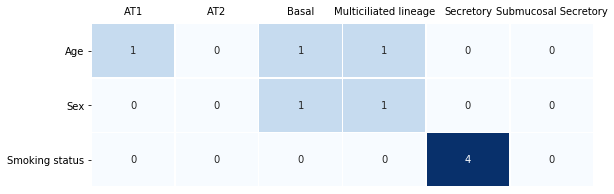

In [83]:
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT1', 'AT2', 'Basal', 'Multiciliated lineage', 'Secretory', 'Submucosal Secretory']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity','')]].pivot(index='covariate', columns='cell_identity')

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = ['Age', 'Sex', 'Smoking status']

rcParams['figure.figsize'] = (9,3)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ace2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

[Text(0, 0.5, 'Age'), Text(0, 1.5, 'Sex'), Text(0, 2.5, 'Smoking status')]

Text(23.999999999999993, 0.5, '')

Text(0.5, 6.0, '')

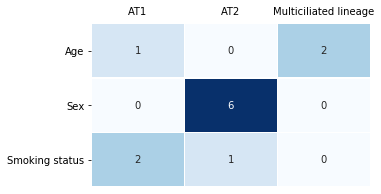

In [84]:
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT1', 'AT2', 'Multiciliated lineage']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity','')]].pivot(index='covariate', columns='cell_identity')

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = ['Age', 'Sex', 'Smoking status']

rcParams['figure.figsize'] = (5,3)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_tmprss2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

[Text(0, 0.5, 'Age'), Text(0, 1.5, 'Sex'), Text(0, 2.5, 'Smoking status')]

Text(32.99999999999999, 0.5, '')

Text(0.5, 6.0, '')

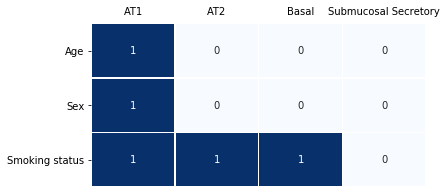

In [85]:
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT1', 'AT2', 'Basal', 'Submucosal Secretory']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity','')]].pivot(index='covariate', columns='cell_identity')

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = ['Age', 'Sex', 'Smoking status']

rcParams['figure.figsize'] = (6,3)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ctsl_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

# Store results

In [54]:
res_summary_lvl2.columns = ['_'.join(col).strip('_') for col in res_summary_lvl2.columns.values]
res_summary_lvl3.columns = ['_'.join(col).strip('_') for col in res_summary_lvl3.columns.values]

In [55]:
res_summary_lvl2.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_summary.csv')
full_res_lvl2_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_full.csv')

In [56]:
res_summary_lvl3.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_summary.csv')
full_res_lvl3_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_full.csv')